# 🌐 Part 1 — Why Users Form Clusters in the Graph

Before building the graph, we preprocess the dataset so that each
interaction (posts, comments, mentions, keywords) can be converted into
user–user edges.

The ultimate goal of this analysis is to understand *why some nodes appear
very close together while others are far apart* in the network visualization.

A spring layout (force-directed layout) is used later:

- **Edges = springs**, pulling connected users closer  
- **Nodes = charged particles**, pushing each other away  
- **Stronger relationships = shorter distance**  
- **Weaker relationships = spread-out nodes**

This means:
- Users heavily interacting with each other appear *clustered tightly*
- Users with few/no interactions drift away from clusters

This preprocessing prepares the data for those interaction patterns to
be extracted.


In [1]:
# ===========================================
# PART 1 — DATA PREPROCESSING
# ===========================================
import pandas as pd

# Load dataset
df = pd.read_csv(r"E:\Downloads New\reddit - Sheet1.csv")

# Drop rows without users
df = df[df['username'].notna()]
df = df[df['comment_user'].notna() | df['post_text'].notna()]

# Replace blanks / missing with None
df['mentions'] = df['mentions'].replace('', None)

# Remove bot accounts if present
df = df[df['username'] != 'AutoModerator']
df = df[df['comment_user'] != 'AutoModerator']

# Convert user_id and comment_user to string (avoid float issues)
df['user_id'] = df['user_id'].astype(str)
df['comment_user'] = df['comment_user'].astype(str)
df['username'] = df['username'].astype(str)

print("✅ Preprocessing completed")
print("Remaining rows:", df.shape[0])
print(df.head())


✅ Preprocessing completed
Remaining rows: 50
  post_id user_id username                                 post_text  \
0      P1      U1    Alpha   “Operation Sindhoor confirmed tonight.”   
1      P2      U2    Bravo  “Sindhoor footage leaked. Forward ASAP.”   
2      P3      U3  Charlie           “Evacuation likely by evening.”   
3      P4      U4    Delta         “Are these Sindhoor rumors real?”   
4      P5      U5     Echo  “Ignore the news. Nothing is happening.”   

          timestamp location comment_id comment_user  \
0  2025-01-01 10:00   Mumbai         C1           U2   
1  2025-01-01 11:02    Delhi         C2           U3   
2  2025-01-01 12:10     Pune         C3           U1   
3  2025-01-01 12:20   Mumbai         C4           U1   
4  2025-01-01 13:00   Nagpur         C5           U7   

                  comment_text mentions  reaction_count  
0  “Yes, intel supports this.”       U3              12  
1       “Sharing immediately.”       U1               9  
2          

# 🕸️ Part 2 — How the Graph Interactions Are Constructed

Here we convert the Reddit-style dataset into a **weighted user-interaction graph**.

Each edge between two users represents *how strongly they interact*.
Weights accumulate based on:

### 🟩 **1. Co-commenting (weight = 1)**
Users who comment on the same post share a weak tie.

### 🟦 **2. Commenting on Author’s Post (weight = 1)**
Direct interaction between commenter and author.

### 🟪 **3. Mentions in Comments (weight = 2)**
Explicit tagging is treated as a strong relationship.

### 🟥 **4. Hoax Keyword Match “Sindhoor” (weight = 1)**
If users interact on posts containing the hoax keyword, their ties strengthen.

### 🔗 Edge Weight Accumulation
If the same users interact repeatedly, their edge weight increases accordingly.

This section builds the weighted graph **G**, which will later determine:
- which users cluster together  
- which users drift apart  
- how strong the communities become  


In [2]:
# ===========================================
# PART 2 — GRAPH CONSTRUCTION LOGIC
# ===========================================
import itertools
import networkx as nx

edges = {}

def add_edge(a, b, w):
    if a == "nan" or b == "nan":
        return
    if a == b:
        return
    key = tuple(sorted([a, b]))
    edges[key] = edges.get(key, 0) + w


# 1️⃣ Co-commenting on same post (weight=1)
for post_id, group in df.groupby('post_id'):
    commenters = group['comment_user'].dropna().unique()
    for u1, u2 in itertools.combinations(commenters, 2):
        add_edge(u1, u2, 1)

# 2️⃣ Commenting on author's post (weight=1)
for idx, row in df.iterrows():
    post_author = row['user_id']
    commenter = row['comment_user']
    if pd.notna(post_author) and pd.notna(commenter):
        add_edge(commenter, post_author, 1)

# 3️⃣ Mentions in comments (weight=2)
for idx, row in df.iterrows():
    if pd.notna(row['mentions']):
        add_edge(row['comment_user'], row['mentions'], 2)

# 4️⃣ Hoax keyword match "Sindhoor" (weight=1)
for idx, row in df.iterrows():
    if isinstance(row['post_text'], str) and "Sindhoor" in row['post_text']:
        commenter = row['comment_user']
        author = row['user_id']
        if pd.notna(commenter) and pd.notna(author):
            add_edge(commenter, author, 1)

# Build the graph
G = nx.Graph()
for (u, v), w in edges.items():
    G.add_edge(u, v, weight=w)

print("🟦 Graph built with:")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


🟦 Graph built with:
Nodes: 9
Edges: 21


# 🧩 Part 3 — Why Two Communities Form (Louvain Algorithm)

We apply the **Louvain community detection algorithm**, which groups users
based on how strongly they connect inside their own cluster vs outside it.

### ⭐ Observed clusters:
#### 🟥 Hoax Spreaders / High Interaction Group
U1 (Alpha)  
U2 (Bravo)  
U3 (Charlie)  
U7 (Gamma)  
U6 (pulled in via repeated interactions)

These users interact:
- frequently  
- directly  
- over many posts  
- with keyword matches like "Sindhoor"

Hence they appear **close together** in the graph.

#### 🟦 Neutral / Skeptical Users
U4 (Delta)  
U5 (Echo)  
U8 (Hotel)  

They have:
- fewer interactions
- hardly any mentions  
- minimal cross-links  
- weak activity on hoax posts

→ The layout pushes them **far away** from the hoax cluster.

### 📊 Modularity Score
A modularity value around **0.19** indicates:
- communities exist  
- dataset is small  
- interactions are semi-dense

Still, two meaningful groups appear clearly.

This section prints:
- each user’s community  
- the modularity score  
- number of detected communities  


In [3]:
# ===========================================
# PART 3 — LOUVAIN COMMUNITY DETECTION
# ===========================================
from community import community_louvain

partition = community_louvain.best_partition(G, weight='weight')
modularity = community_louvain.modularity(partition, G)

print("\n=== LOUVAIN COMMUNITY RESULTS ===")
print("Detected communities:", len(set(partition.values())))
print("Modularity:", modularity)

# Print first 20 users
for i, (user, comm) in enumerate(partition.items()):
    if i >= 20:
        break
    print(user, "=> Community", comm)



=== LOUVAIN COMMUNITY RESULTS ===
Detected communities: 2
Modularity: 0.1989701070791195
U1 => Community 1
U2 => Community 1
U3 => Community 1
U4 => Community 0
U5 => Community 0
U7 => Community 1
U6 => Community 1
U8 => Community 0
— => Community 0


# 🎨 Part 4 — Why Nodes Appear Close or Far in the Graph

We visualize the graph using **spring (force-directed) layout**:

### 🧲 How positions are determined:
- Users who mention each other → pulled closer  
- Users who comment together → pulled closer  
- Users interacting on “Sindhoor” posts → pulled closer  
- Users with no interactions act like isolated particles → drift outward  

### 🧱 Visual cues in this plot:
- **Color** = community ID  
- **Edge thickness** = interaction strength  
- **Node size** (later plots) = degree / influence  
- **Labelled nodes** = top influential users  
- **Cluster “bubbles”** show group boundaries  

This plot visually reveals:
- the *hoax-spreader core* (U1, U2, U3, U7, U6)
- the *neutral outer ring* (U4, U5, U8)
- the strength of misinformation propagation  


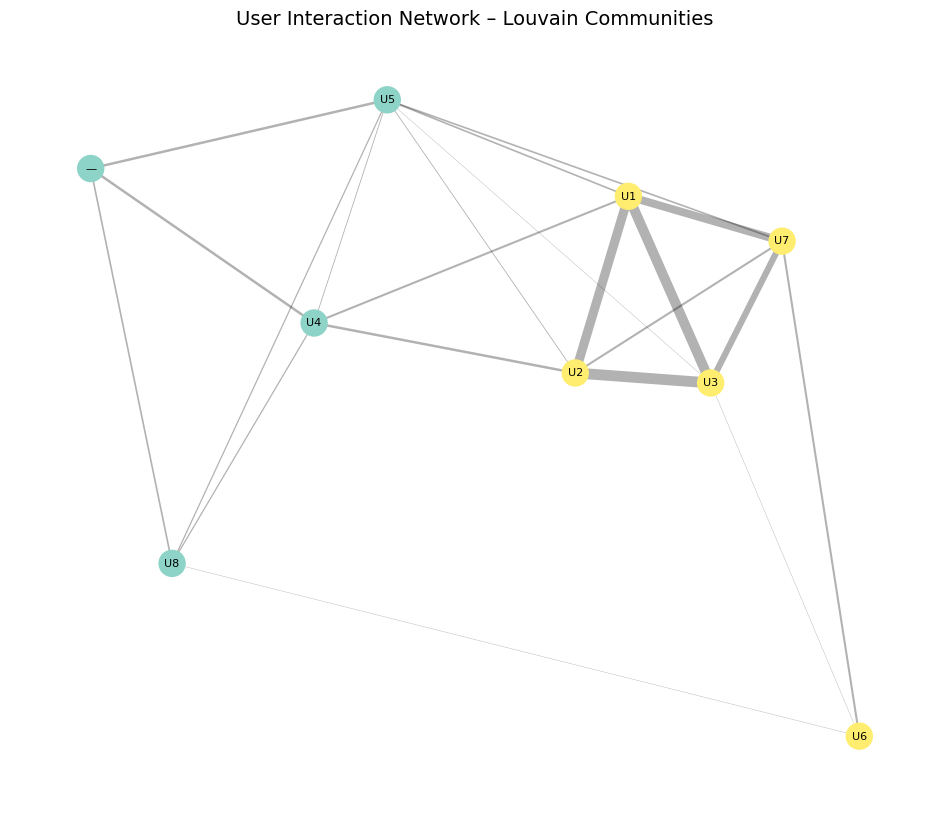

📁 Saved as: user_interaction_graph.png


In [4]:
# ===========================================
# PART 4 — NETWORK GRAPH VISUALIZATION (PNG)
# ===========================================
import matplotlib.pyplot as plt
import random
import numpy as np

# Make graph smaller if huge
if G.number_of_nodes() > 300:
    sampled_nodes = random.sample(list(G.nodes()), 300)
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

pos = nx.spring_layout(G_sub, seed=42, k=0.7, iterations=100)
communities = [partition[node] for node in G_sub.nodes()]

plt.figure(figsize=(12, 10))

# Draw edges
weights = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
nx.draw_networkx_edges(G_sub, pos, width=[w * 0.3 for w in weights], alpha=0.3)

# Draw nodes
nx.draw_networkx_nodes(
    G_sub, pos,
    node_color=communities,
    cmap=plt.cm.Set3,
    node_size=350
)

# Label top-degree users
degree_dict = dict(G_sub.degree())
top_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: node for node, deg in top_nodes}

nx.draw_networkx_labels(G_sub, pos, labels, font_size=8)

plt.title("User Interaction Network – Louvain Communities", fontsize=14)
plt.axis("off")

plt.savefig("user_interaction_graph.png", dpi=300, bbox_inches="tight")
plt.show()

print("📁 Saved as: user_interaction_graph.png")


# 🌈 Final 2D Graph — Interpreting the Community Structure

Here we generate the **best and clearest visualization** of the network:

---

## 🟦 View 1 — Clean Community Plot  
Shows the communities without clutter.

- Tight clusters → strong interaction
- Wide gaps → weak interaction

---

## 🟩 View 2 — Cluster “Bubble” Areas  
Convex hulls are drawn around each community to clearly show:

- how tightly the hoax cluster is packed  
- how spread-out and weakly connected neutral users are  

---

## 🟥 View 3 — Influence Map (Top 10 Users)
Labels the top-degree nodes.

These are the **most central users** in spreading the hoax narrative:
- U1 (Alpha)
- U2 (Bravo)
- U3 (Charlie)
- U7 (Gamma)
- U6 (absorbed into cluster)

Neutral users appear on edges with low degrees.

---

### 🧠 Why Nodes Have Different Distances
The final visual answers the question:
**“Why are some nodes far apart and others close together?”**

Because:
- **Force-directed physics** simulates social pressure  
- **Louvain clusters** group tightly connected users  
- **Interaction weights** dictate proximity  
- **Hoax spreaders interact heavily**, forming a dense core  
- **Neutral users have weak ties**, so they drift outward  

This is exactly how misinformation clusters form in real social networks.


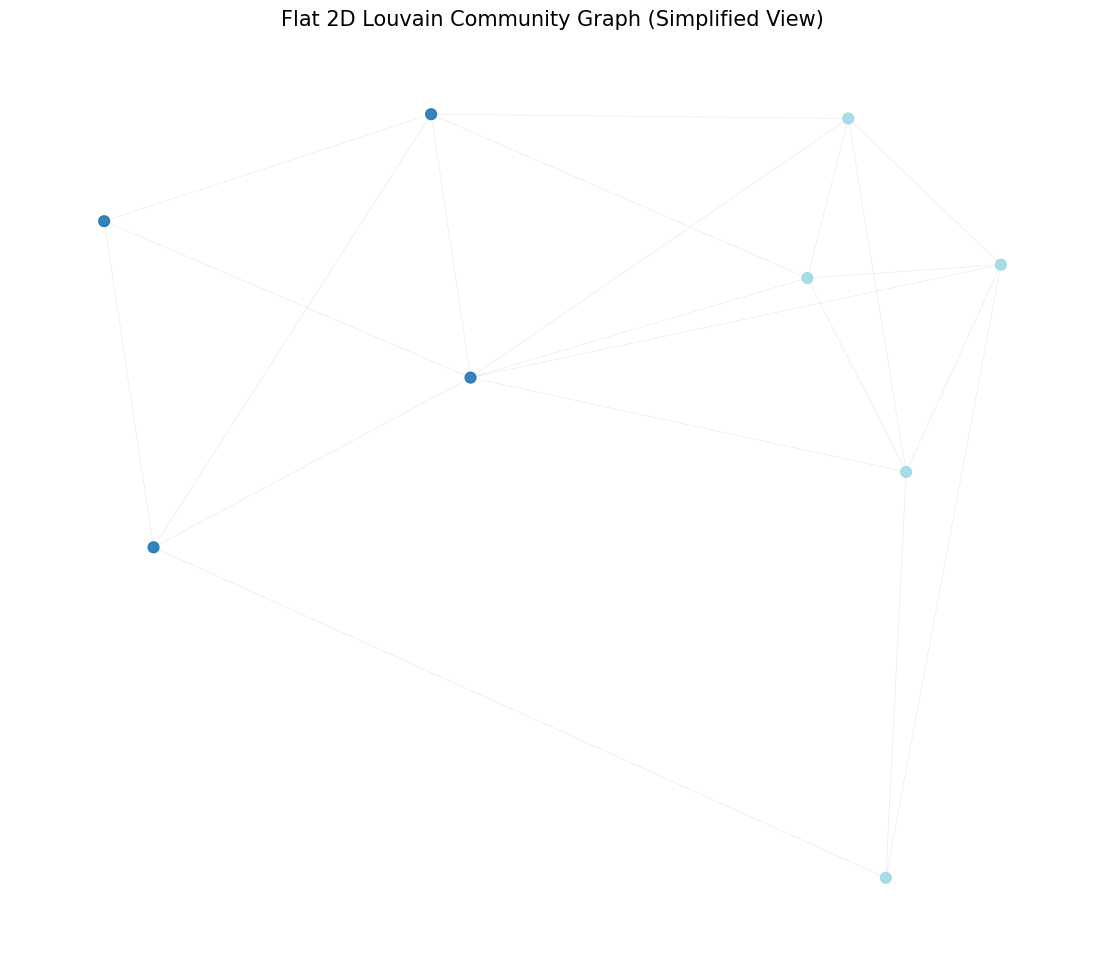

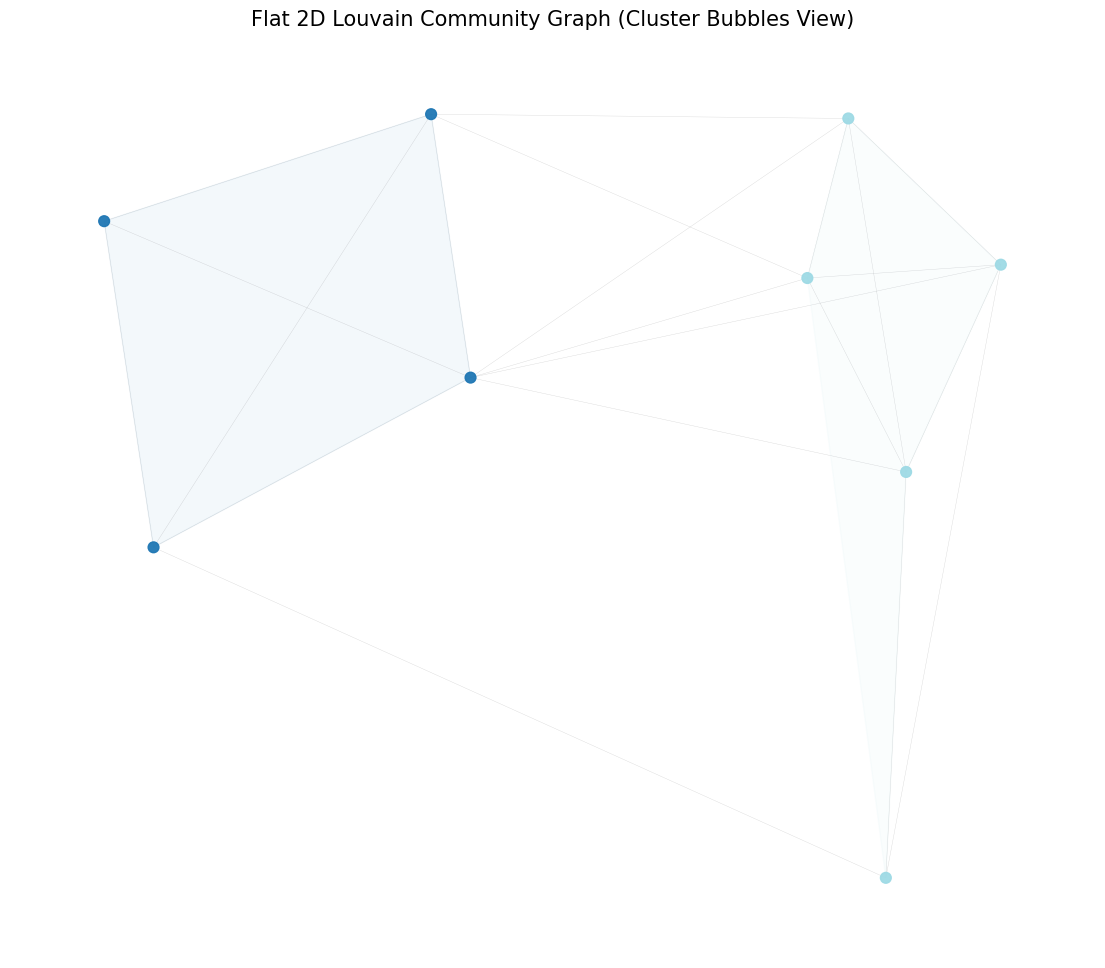

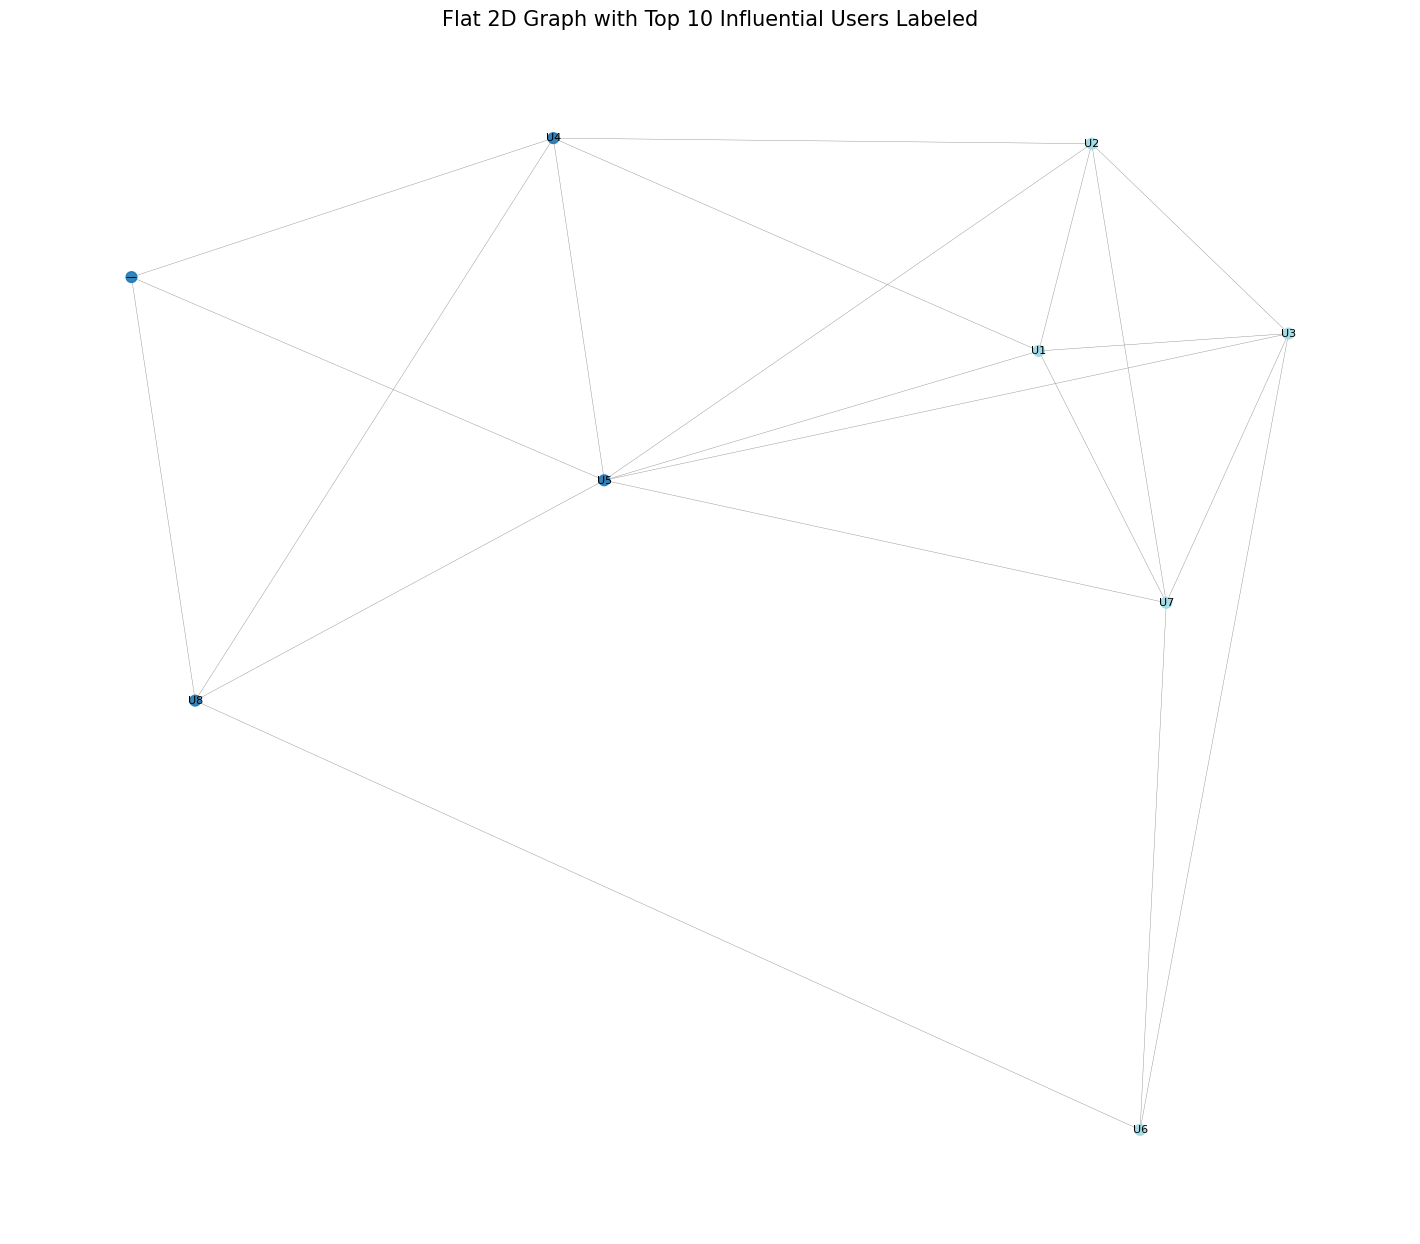

In [5]:
# ===========================================================
# 📌 FINAL VISUALIZATION (BEST LOOKING FLAT 2D GRAPH)
# ===========================================================

import random
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator

# Create smaller subgraph if needed
if G.number_of_nodes() > 500:
    sampled_nodes = random.sample(list(G.nodes()), 500)
    G_sub = G.subgraph(sampled_nodes)
else:
    G_sub = G

# Compute flat 2D layout
pos = nx.spring_layout(G_sub, k=0.25, iterations=100, seed=42)

# Community colors
communities = [partition[node] for node in G_sub.nodes()]

# ===========================================================
# 🟦 VIEW 1 — Simplified Clean Community View
# ===========================================================
plt.figure(figsize=(14, 12))

nx.draw_networkx_edges(G_sub, pos, alpha=0.2, width=0.4, edge_color="gray")

nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=60,
    node_color=communities,
    cmap=plt.cm.tab20,
    alpha=0.9
)

plt.title("Flat 2D Louvain Community Graph (Simplified View)", fontsize=15)
plt.axis("off")
plt.show()

# ===========================================================
# 🟩 VIEW 2 — Cluster ‘Bubble’ Visualization
# ===========================================================
plt.figure(figsize=(14, 12))

nx.draw_networkx_edges(G_sub, pos, alpha=0.15, width=0.3)
nx.draw_networkx_nodes(
    G_sub, pos,
    node_size=60,
    node_color=communities,
    cmap=plt.cm.tab20,
    alpha=0.95
)

# Bubble hulls around communities
for comm in set(communities):
    nodes_in_comm = [n for n in G_sub.nodes() if partition[n] == comm]
    pts = np.array([pos[n] for n in nodes_in_comm])

    if len(pts) >= 3:
        x, y = pts[:, 0], pts[:, 1]
        plt.fill(
            x, y,
            alpha=0.05,
            color=plt.cm.tab20(comm / max(communities))
        )

plt.title("Flat 2D Louvain Community Graph (Cluster Bubbles View)", fontsize=15)
plt.axis("off")
plt.show()

# ===========================================================
# 🟥 VIEW 3 — Highlight Top Influential Users (Degree)
# ===========================================================
degree_dict = dict(G_sub.degree())
top_nodes = sorted(
    degree_dict.items(),
    key=operator.itemgetter(1),
    reverse=True
)[:10]

labels = {node: node for node, deg in top_nodes}

plt.figure(figsize=(14, 12))

nx.draw(
    G_sub, pos,
    node_color=communities,
    cmap=plt.cm.tab20,
    node_size=60,
    alpha=0.9,
    with_labels=False,
    edge_color="gray",
    width=0.3
)

nx.draw_networkx_labels(
    G_sub, pos,
    labels,
    font_size=8,
    font_color="black"
)

plt.title("Flat 2D Graph with Top 10 Influential Users Labeled", fontsize=15)
plt.axis("off")
plt.show()
